In [1]:
import sys
import os
# Add the 'scripts/' directory to the system path
sys.path.append(os.path.abspath('../triple_mbhb'))

In [2]:
import Trip_utils as util
import numpy as np
import Triple_dynamics as Tr
import spin_models as spin
import matplotlib.pyplot as plt
from tqdm import tqdm
import Trip_utils as util
import Kickrateplots as kickplots
import merger_rate_calculate as mr
from scipy.stats import binned_statistic

In [3]:
import astropy.units as u
from astropy import constants as const

import BH_kicks as kick
import spin_models as spin
import count_vkicks as kickcount
import count_ejections as ejects

In [4]:
import os
tex_path = '/apps/texlive/2023/bin/x86_64-linux/'
os.environ['PATH'] += os.pathsep + tex_path

In [5]:
import scienceplots
plt.style.use('science')

In [6]:
def set_plot_style(linewidth=3, titlesize=20,labelsize=25,ticksize=20,legendsize=20,bold=True):
        """Set matplotlib rcParams for consistent plot style."""
        font_weight = 'bold' if bold else 'normal'

        plt.rcParams.update({
            'lines.linewidth': linewidth,
            'axes.labelsize': labelsize,
            'axes.titlesize': titlesize,
            'xtick.labelsize': ticksize,
            'ytick.labelsize': ticksize,
            'legend.fontsize': legendsize,
            'axes.titleweight': font_weight,
            'axes.labelweight': font_weight,
            'font.weight': font_weight,
        })


### Load the objects

In [7]:
import pickle
Nruns = 100

iso_filename = os.path.abspath('../obj_data/iso_bin_wkick.pkl')
weak_tr_filename = os.path.abspath('../obj_data/weak_tr_wkick.pkl')
strong_tr_filename =os.path.abspath(f'../obj_data/tr{Nruns}_wkick.pkl')
stalled_tr_filename=os.path.abspath(f'../obj_data/stalled{Nruns}.pkl')

In [8]:
with open(iso_filename, 'rb') as f:
    iso_bin = pickle.load(f)

with open(weak_tr_filename, 'rb') as f:
    weak_tr = pickle.load(f)

with open(strong_tr_filename, 'rb') as f:
    strong_tr = pickle.load(f)

with open(stalled_tr_filename, 'rb') as f:
    stalled_objs = pickle.load(f)

### Spin model distributions

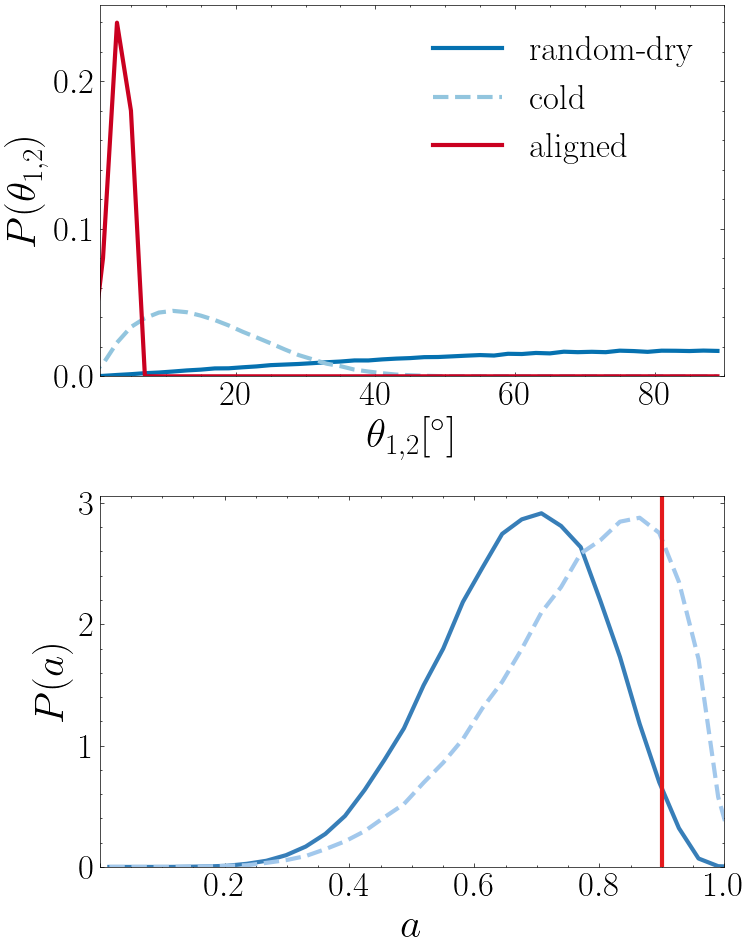

In [9]:
set_plot_style(linewidth=3,labelsize=30,legendsize=25,ticksize=25)

fig,axes = kickplots.plot_spin_dist()
fig.savefig("../Figures/spin-models-magnitude-and-angle.pdf")

In [10]:
velocity_bins_rand = np.logspace(1,4,50) 
velocity_bins_sling = np.logspace(1.7,4,20) 

In [11]:
slingshot_kick_counts = []
for i in range(Nruns):
    sling_kick_N, _ = np.histogram(strong_tr[i].slingshot_kicks,bins=velocity_bins_sling)
    slingshot_kick_counts.append(sling_kick_N)

mean_sling = np.mean(slingshot_kick_counts,axis=0)
std_sling = np.std(slingshot_kick_counts,axis=0)

In [12]:
rand_kick_counts= kickcount.Nvkicks(iso_bin,weak_tr,strong_tr,Nruns,velocity_bins_rand,kick_type="v_kick_random")
hybrid_kick_counts= kickcount.Nvkicks(iso_bin,weak_tr,strong_tr,Nruns,velocity_bins_rand,kick_type="v_kick_hybrid")
aligned_kick_counts = kickcount.Nvkicks(iso_bin,weak_tr,strong_tr,Nruns,velocity_bins_rand,kick_type="v_kick_aligned")

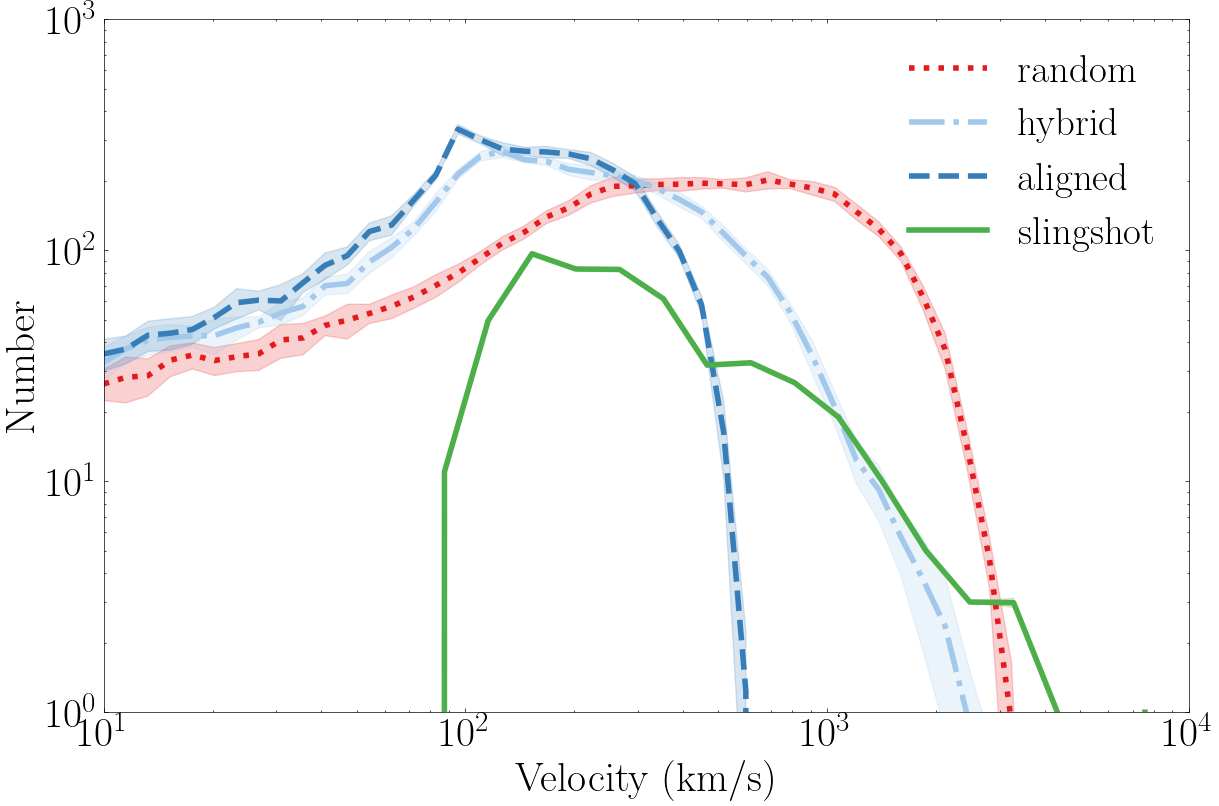

In [ ]:
kick_types_data = {
    'random': (rand_kick_counts, velocity_bins_rand),
    'hybrid': (hybrid_kick_counts, velocity_bins_rand),
    'aligned': (aligned_kick_counts, velocity_bins_rand),
    'slingshot': (slingshot_kick_counts, velocity_bins_sling)
}

set_plot_style(linewidth=4,labelsize=30,legendsize=28,ticksize=30,bold=True)
fig,ax = kickcount.plot_kick_distribution(kick_types_data)
fig.set_size_inches(14,9)
ax.legend(loc='upper yright')
fig
fig.savefig("../Figures/v-dist-for-all-kicks.pdf")

#### Maximum kick produced, Median of kick speeds"

In [21]:
maximum_v_random = []
maximum_v_hybrid = []
maximum_v_aligned = []
maximum_v_slingshot = []

for i in range(Nruns):
    maximum_v_random.append(np.mean(np.max((np.max(iso_bin.v_kick_random,axis=1),np.max(weak_tr.v_kick_random,axis=1),np.max(strong_tr[i].v_kick_random,axis=1)),axis=0)))
    maximum_v_hybrid.append(np.mean(np.max((np.max(iso_bin.v_kick_hybrid,axis=1),np.max(weak_tr.v_kick_hybrid,axis=1),np.max(strong_tr[i].v_kick_hybrid,axis=1)),axis=0)))
    maximum_v_aligned.append(np.mean(np.max((np.max(iso_bin.v_kick_aligned,axis=1),np.max(weak_tr.v_kick_aligned,axis=1),np.max(strong_tr[i].v_kick_aligned,axis=1)),axis=0)))
    maximum_v_slingshot.append(np.max(strong_tr[i].slingshot_kicks))



print(f"The maximum kick produced by GW recoil using random spins is {np.mean(maximum_v_random):.2f}  km/s")
print(f"The maximum kick produced by GW recoil using hybrid spins is {np.mean(maximum_v_hybrid):.2f} km/s")
print(f"The maximum kick produced by GW recoil using aligned spins is {np.mean(maximum_v_aligned):.2f}  km/s")
print(f"The maximum kick produced by slingshot using random spins is {np.mean(maximum_v_slingshot):.2f}  km/s")

The maximum kick produced by GW recoil using random spins is 3226.01  km/s
The maximum kick produced by GW recoil using hybrid spins is 2622.36 km/s
The maximum kick produced by GW recoil using aligned spins is 602.64  km/s
The maximum kick produced by slingshot using random spins is 8368.36  km/s


In [22]:
median_v_random = []
median_v_hybrid = []
median_v_aligned = []
median_v_slingshot = []

for i in range(Nruns):
    median_v_random.append(np.median(np.concatenate((iso_bin.v_kick_random, 
                                                     weak_tr.v_kick_random, 
                                                     strong_tr[i].v_kick_random), axis=1)))
    median_v_hybrid.append(np.median(np.concatenate((iso_bin.v_kick_hybrid, 
                                                     weak_tr.v_kick_hybrid, 
                                                     strong_tr[i].v_kick_hybrid), axis=1)))
    median_v_aligned.append(np.median(np.concatenate((iso_bin.v_kick_aligned, 
                                                      weak_tr.v_kick_aligned, 
                                                      strong_tr[i].v_kick_aligned), axis=1)))
    median_v_slingshot.append(np.median(strong_tr[i].slingshot_kicks))

# Print results
print(f"The median kick velocity produced by GW recoil using random spins is {np.mean(median_v_random):.2f} km/s")
print(f"The median kick velocity produced by GW recoil using hybrid spins is {np.mean(median_v_hybrid):.2f} km/s")
print(f"The median kick velocity produced by GW recoil using aligned spins is {np.mean(median_v_aligned):.2f} km/s")
print(f"The median kick velocity produced by slingshot is {np.mean(median_v_slingshot):.2f} km/s")


The median kick velocity produced by GW recoil using random spins is 312.15 km/s
The median kick velocity produced by GW recoil using hybrid spins is 142.61 km/s
The median kick velocity produced by GW recoil using aligned spins is 111.41 km/s
The median kick velocity produced by slingshot is 280.57 km/s


#### Percentiles of kick velocities

In [23]:
# Initialize lists to store results
random_percentile_1000 = []
random_percentile_1000_std = []
hybrid_percentile_1000 = []
hybrid_percentile_1000_std = []
aligned_percentile_1000 = []
aligned_percentile_1000_std = []
slingshot_percentile_1000 = []


random_percentile_500 = []
random_percentile_500_std = []
hybrid_percentile_500 = []
hybrid_percentile_500_std = []
aligned_percentile_500 = []
aligned_percentile_500_std = []
slingshot_percentile_500 = []


# Main loop for Nruns
for i in range(Nruns):
    # Total number of kicks
    N_kicks_i = (
        np.shape(iso_bin.v_kick_random)[1] + 
        np.shape(weak_tr.v_kick_random)[1] + 
        np.shape(strong_tr[i].v_kick_random)[1]
    )
    
    # Random kicks above thresholds
    N_rand_above_1000 = (
        np.sum(np.array(iso_bin.v_kick_random) > 1000, axis=1) + 
        np.sum(np.array(weak_tr.v_kick_random) > 1000, axis=1) + 
        np.sum(np.array(strong_tr[i].v_kick_random) > 1000, axis=1)
    )
    random_percentile_1000.append(np.mean(N_rand_above_1000 / N_kicks_i * 100))
    random_percentile_1000_std.append(np.std(N_rand_above_1000 / N_kicks_i * 100))
    
    N_rand_above_500 = (
        np.sum(np.array(iso_bin.v_kick_random) > 500, axis=1) + 
        np.sum(np.array(weak_tr.v_kick_random) > 500, axis=1) + 
        np.sum(np.array(strong_tr[i].v_kick_random) > 500, axis=1)
    )
    random_percentile_500.append(np.mean(N_rand_above_500 / N_kicks_i * 100))
    random_percentile_500_std.append(np.std(N_rand_above_500 / N_kicks_i * 100))
    
    # Hybrid kicks above thresholds
    N_hybrid_above_1000 = (
        np.sum(np.array(iso_bin.v_kick_hybrid) > 1000, axis=1) + 
        np.sum(np.array(weak_tr.v_kick_hybrid) > 1000, axis=1) + 
        np.sum(np.array(strong_tr[i].v_kick_hybrid) > 1000, axis=1)
    )
    hybrid_percentile_1000.append(np.mean(N_hybrid_above_1000 / N_kicks_i * 100))
    hybrid_percentile_1000_std.append(np.std(N_hybrid_above_1000 / N_kicks_i * 100))
    
    N_hybrid_above_500 = (
        np.sum(np.array(iso_bin.v_kick_hybrid) > 500, axis=1) + 
        np.sum(np.array(weak_tr.v_kick_hybrid) > 500, axis=1) + 
        np.sum(np.array(strong_tr[i].v_kick_hybrid) > 500, axis=1)
    )
    hybrid_percentile_500.append(np.mean(N_hybrid_above_500 / N_kicks_i * 100))
    hybrid_percentile_500_std.append(np.std(N_hybrid_above_500 / N_kicks_i * 100))
    
    # Aligned kicks above thresholds
    N_aligned_above_1000 = (
        np.sum(np.array(iso_bin.v_kick_aligned) > 1000, axis=1) + 
        np.sum(np.array(weak_tr.v_kick_aligned) > 1000, axis=1) + 
        np.sum(np.array(strong_tr[i].v_kick_aligned) > 1000, axis=1)
    )
    aligned_percentile_1000.append(np.mean(N_aligned_above_1000 / N_kicks_i * 100))
    aligned_percentile_1000_std.append(np.std(N_aligned_above_1000 / N_kicks_i * 100))
    
    N_aligned_above_500 = (
        np.sum(np.array(iso_bin.v_kick_aligned) > 500, axis=1) + 
        np.sum(np.array(weak_tr.v_kick_aligned) > 500, axis=1) + 
        np.sum(np.array(strong_tr[i].v_kick_aligned) > 500, axis=1)
    )
    aligned_percentile_500.append(np.mean(N_aligned_above_500 / N_kicks_i * 100))
    aligned_percentile_500_std.append(np.std(N_aligned_above_500 / N_kicks_i * 100))
    
    # Slingshot kicks above thresholds (only for strong_tr[i])
    N_slingshot_above_1000 = np.sum(np.array(strong_tr[i].slingshot_kicks) > 1000)
    slingshot_percentile_1000.append(N_slingshot_above_1000 /520* 100)
   
    N_slingshot_above_500 = np.sum(np.array(strong_tr[i].slingshot_kicks) > 500)
    slingshot_percentile_500.append(N_slingshot_above_500 /520 * 100)
   


In [24]:
# Output results for kicks above 1000 and 500 with formatted print statements
print(f"The % of kicks above 1000 in random model is {np.mean(random_percentile_1000):.2f} ± {np.mean(random_percentile_1000_std):.2f} %")
print(f"The % of kicks above 500 in random model is {np.mean(random_percentile_500):.2f} ± {np.mean(random_percentile_500_std):.2f} %")
print("----------")
print(f"The % of kicks above 1000 in hybrid model is {np.mean(hybrid_percentile_1000):.2f} ± {np.mean(hybrid_percentile_1000_std):.2f} %")
print(f"The % of kicks above 500 in hybrid model is {np.mean(hybrid_percentile_500):.2f} ± {np.mean(hybrid_percentile_500_std):.2f} %")
print("----------")
print(f"The % of kicks above 1000 in aligned model is {np.mean(aligned_percentile_1000):.2f} ± {np.mean(aligned_percentile_1000_std):.2f} %")
print(f"The % of kicks above 500 in aligned model is {np.mean(aligned_percentile_500):.2f} ± {np.mean(aligned_percentile_500_std):.2f} %")
print("----------")
print(f"The % of kicks above 1000 in slingshot model is {np.mean(slingshot_percentile_1000):.2f} ± {np.std(slingshot_percentile_1000):.2f} %")
print(f"The % of kicks above 500 in slingshot model is {np.mean(slingshot_percentile_500):.2f} ± {np.std(slingshot_percentile_500):.2f} %")

The % of kicks above 1000 in random model is 15.43 ± 0.54 %
The % of kicks above 500 in random model is 36.16 ± 0.44 %
----------
The % of kicks above 1000 in hybrid model is 1.38 ± 0.16 %
The % of kicks above 500 in hybrid model is 9.85 ± 0.50 %
----------
The % of kicks above 1000 in aligned model is 0.00 ± 0.00 %
The % of kicks above 500 in aligned model is 0.61 ± 0.08 %
----------
The % of kicks above 1000 in slingshot model is 10.22 ± 0.19 %
The % of kicks above 500 in slingshot model is 23.88 ± 0.24 %


In [25]:
def count_kicks_in_range(v_min, v_max, Nruns, iso_bin, weak_tr, strong_tr):
    # Initialize lists to store the number of kicks in the velocity range
    kicks_in_range_random = []
    kicks_in_range_hybrid = []
    kicks_in_range_aligned = []
    kicks_in_range_slingshot = []

    for i in range(Nruns):
        # Random spins
        random_kicks = np.concatenate((iso_bin.v_kick_random, 
                                        weak_tr.v_kick_random, 
                                        strong_tr[i].v_kick_random), axis=1)
        # Count kicks in the specified velocity range directly
        kicks_in_range_random.append(np.sum((random_kicks >= v_min) & (random_kicks <= v_max)))

        # Hybrid spins
        hybrid_kicks = np.concatenate((iso_bin.v_kick_hybrid, 
                                        weak_tr.v_kick_hybrid, 
                                        strong_tr[i].v_kick_hybrid), axis=1)
        # Count kicks in the specified velocity range directly
        kicks_in_range_hybrid.append(np.sum((hybrid_kicks >= v_min) & (hybrid_kicks <= v_max)))

        # Aligned spins
        aligned_kicks = np.concatenate((iso_bin.v_kick_aligned, 
                                         weak_tr.v_kick_aligned, 
                                         strong_tr[i].v_kick_aligned), axis=1)
        # Count kicks in the specified velocity range directly
        kicks_in_range_aligned.append(np.sum((aligned_kicks >= v_min) & (aligned_kicks <= v_max)))

        # Slingshot kicks (only in strong_tr)
        slingshot_kicks = np.array(strong_tr[i].slingshot_kicks)
        # Count kicks in the specified velocity range directly
        kicks_in_range_slingshot.append(np.sum((slingshot_kicks >= v_min) & (slingshot_kicks <= v_max)))

    # Return the results as a dictionary
    return {
        "random": np.mean(kicks_in_range_random),
        "hybrid": np.mean(kicks_in_range_hybrid),
        "aligned": np.mean(kicks_in_range_aligned),
        "slingshot": np.mean(kicks_in_range_slingshot)
    }

# Example usage:


In [26]:
v_min = 500
v_max = 550
results = count_kicks_in_range(v_min, v_max, Nruns, iso_bin, weak_tr, strong_tr)

# Print the results
print(f"The number of kicks in the {v_min}-{v_max} km/s range for random spins is {results['random']}")
print(f"The number of kicks in the {v_min}-{v_max} km/s range for hybrid spins is {results['hybrid']}")
print(f"The number of kicks in the {v_min}-{v_max} km/s range for aligned spins is {results['aligned']}")
print(f"The number of kicks in the {v_min}-{v_max} km/s range for slingshot is {results['slingshot']}")


The number of kicks in the 500-550 km/s range for random spins is 1283.08
The number of kicks in the 500-550 km/s range for hybrid spins is 853.98
The number of kicks in the 500-550 km/s range for aligned spins is 204.62
The number of kicks in the 500-550 km/s range for slingshot is 7.14


In [32]:
v_min = 3350
v_max = 9000
results = count_kicks_in_range(v_min, v_max, Nruns, iso_bin, weak_tr, strong_tr)

# Print the results
print(f"The number of kicks in the {v_min}-{v_max} km/s range for random spins is {results['random']}")
print(f"The number of kicks in the {v_min}-{v_max} km/s range for hybrid spins is {results['hybrid']}")
print(f"The number of kicks in the {v_min}-{v_max} km/s range for aligned spins is {results['aligned']}")
print(f"The number of kicks in the {v_min}-{v_max} km/s range for slingshot is {results['slingshot']}")


The number of kicks in the 3350-9000 km/s range for random spins is 3.32
The number of kicks in the 3350-9000 km/s range for hybrid spins is 0.0
The number of kicks in the 3350-9000 km/s range for aligned spins is 0.0
The number of kicks in the 3350-9000 km/s range for slingshot is 4.96


### % of ejected 

In [33]:
random_ejections = []
hybrid_ejections = []
aligned_ejections = []
slingshot_ejections = []

for i in range(Nruns):

    # Total number of kicks
    N_kicks = (np.shape(iso_bin.v_kick_random)[1]) + (np.shape(weak_tr.v_kick_random)[1]) + (np.shape(strong_tr[i].v_kick_random)[1])
    
    # Slingshot kicks (assuming there is 520 slingshot kicks per iteration)
    N_sling_kicks = 520
    
    # Calculate ejections for random spins
    random_ejections.append((np.sum(iso_bin.v_kick_random > iso_bin.Vescape[iso_bin.merger_mask], axis=1) +
                             np.sum(weak_tr.v_kick_random > weak_tr.Vescape[weak_tr.merger_mask], axis=1) +
                             np.sum(strong_tr[i].v_kick_random > strong_tr[i].Vescape[strong_tr[i].merger_mask], axis=1)) / N_kicks * 100)
    
    # Calculate ejections for hybrid spins
    hybrid_ejections.append((np.sum(iso_bin.v_kick_hybrid > iso_bin.Vescape[iso_bin.merger_mask], axis=1) +
                             np.sum(weak_tr.v_kick_hybrid > weak_tr.Vescape[weak_tr.merger_mask], axis=1) +
                             np.sum(strong_tr[i].v_kick_hybrid > strong_tr[i].Vescape[strong_tr[i].merger_mask], axis=1)) / N_kicks * 100)

    # Calculate ejections for aligned spins
    aligned_ejections.append((np.sum(iso_bin.v_kick_aligned > iso_bin.Vescape[iso_bin.merger_mask], axis=1) +
                              np.sum(weak_tr.v_kick_aligned > weak_tr.Vescape[weak_tr.merger_mask], axis=1) +
                              np.sum(strong_tr[i].v_kick_aligned > strong_tr[i].Vescape[strong_tr[i].merger_mask], axis=1)) / N_kicks * 100)

    # Slingshot kicks (for each strong_tr[i].slingshot_kicks, we compare with escape velocity)
    slingshot_ejections.append(np.sum(strong_tr[i].slingshot_kicks > strong_tr[i].Vescape) / N_sling_kicks * 100)



In [34]:
print(f"Random ejection percentage: {np.mean(random_ejections):.2f}% ± {np.std(random_ejections):.2f}%")
print(f"Hybrid ejection percentage: {np.mean(hybrid_ejections):.2f}% ± {np.std(hybrid_ejections):.2f}%")
print(f"Aligned ejection percentage: {np.mean(aligned_ejections):.2f}% ± {np.std(aligned_ejections):.2f}%")
print(f"Slingshot ejection percentage: {np.mean(slingshot_ejections):.2f}% ± {np.std(slingshot_ejections):.2f}%")

Random ejection percentage: 14.93% ± 0.31%
Hybrid ejection percentage: 1.86% ± 0.15%
Aligned ejection percentage: 0.27% ± 0.07%
Slingshot ejection percentage: 6.66% ± 0.11%


#### Spin model plot

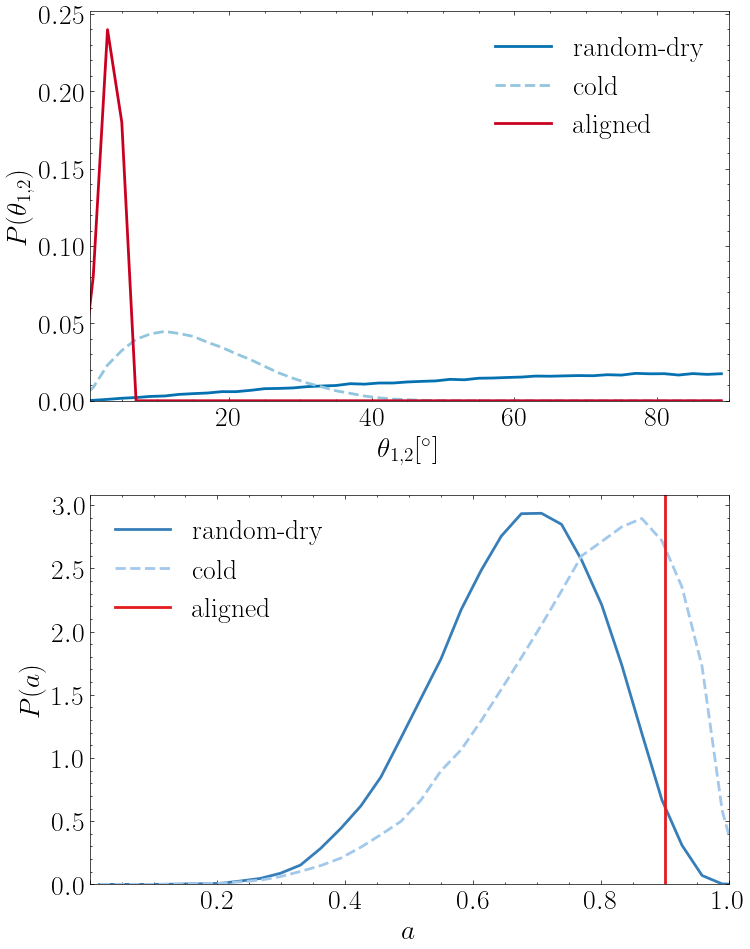

In [33]:
fig,axes = kickplots.plot_spin_dist()
fig.savefig("../Figures/spin-models-magnitude-and-angle.pdf")

## Ejection rates

In [6]:
#assign ejections
ejects.assign_ejection_masks(strong_tr,iso_bin,weak_tr,Nruns)

In [7]:
N_kick_realization = np.shape(strong_tr[0].v_kick_random)[0]

In [11]:
lgzbins_random,st_ejection_rate_random = ejects.strong_tr_ejection_rates(strong_tr, Nruns, N_kick_realization, kick_type='random', lgzbinsize=0.25, lgzmin=-3, lgzmax=1.0)
lgzbins_hybrid,st_ejection_rate_hybrid = ejects.strong_tr_ejection_rates(strong_tr, Nruns, N_kick_realization, kick_type='hybrid',lgzbinsize=0.4,lgzmin=-3,lgzmax=1.0)
lgzbins_aligned,st_ejection_rate_aligned = ejects.strong_tr_ejection_rates(strong_tr, Nruns, N_kick_realization, kick_type='aligned',lgzbinsize=0.4,lgzmin=-3,lgzmax=1.0)
lgzbins_slingshot,st_ejection_rate_slingshot = ejects.strong_tr_ejection_rates(strong_tr, Nruns, N_kick_realization, kick_type='slingshot', lgzbinsize=0.25, lgzmin=-3, lgzmax=1.0)

calculating ejection rates for slingshot: 100%|██████████| 100/100 [00:01<00:00, 57.62it/s]


In [12]:
lgzbins_random_tot, total_ejection_rate_random = ejects.tot_population_ejection_rates(strong_tr, weak_tr, iso_bin, Nruns, N_kick_realization, kick_type="random",lgzbinsize=0.18,lgzmin=-3.2,lgzmax=1.0)
lgzbins_hybrid_tot, total_ejection_rate_hybrid = ejects.tot_population_ejection_rates(strong_tr, weak_tr, iso_bin, Nruns, N_kick_realization, kick_type="hybrid",lgzbinsize=0.4,lgzmin=-3,lgzmax=1.0)
lgzbins_aligned_tot, total_ejection_rate_aligned = ejects.tot_population_ejection_rates(strong_tr, weak_tr, iso_bin, Nruns, N_kick_realization, kick_type="aligned",lgzbinsize=0.2,lgzmin=-3,lgzmax=1.0)

calculating combined ejection rates for aligned: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


In [12]:
savepath = '/Users/pranavsatheesh/Triples/Github/Illustris_Data/'

In [14]:
kick_colors = {
        'slingshot': "#4daf4a",  # Green
        'aligned': "#377eb8",    # Blue
        'hybrid': "#a2c8ec",     # Light blue
        'random': "#e41a1c"      # Red
    }

kick_linestyles = {
        'slingshot': "-",        # Solid line
        'aligned': "--",         # Dashed line
        'hybrid': "-.",          # Dash-dot line
        'random': ":"            # Dotted line
    }

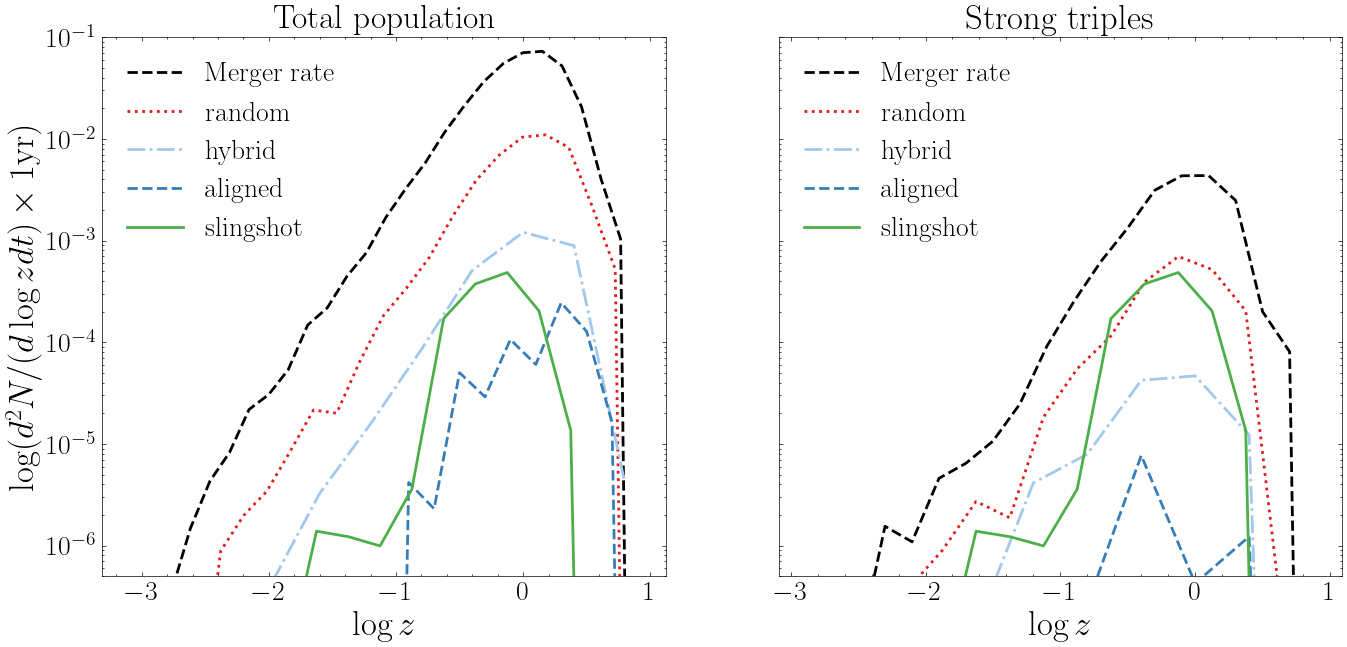

In [52]:
fig,ax = plt.subplots(1,2,figsize=(16,7),sharey=True)

lgz_bins,all_mr = np.loadtxt(savepath+"all_system_merger_rates.txt")    
ax[0].plot(lgz_bins,all_mr,color="black",linestyle="--",label="Merger rate",linewidth=2)
ax[0].plot(lgzbins_random_tot,np.mean(total_ejection_rate_random,axis=0),color=kick_colors['random'],label="random",linewidth=2,linestyle=kick_linestyles['random'])
ax[0].plot(lgzbins_hybrid_tot,np.mean(total_ejection_rate_hybrid,axis=0),color=kick_colors['hybrid'],label="hybrid",linewidth=2,linestyle=kick_linestyles['hybrid'])
ax[0].plot(lgzbins_aligned_tot,np.mean(total_ejection_rate_aligned,axis=0),color=kick_colors['aligned'],label="aligned",linewidth=2,linestyle=kick_linestyles['aligned'])
ax[0].plot(lgzbins_slingshot,np.mean(st_ejection_rate_slingshot,axis=0),color=kick_colors['slingshot'],label="slingshot",linewidth=2,linestyle=kick_linestyles['slingshot'])
ax[0].legend(fontsize=20)
ax[0].set_title("Total population")
ax[0].set_yticks([1e-1,1e-3,1e-5,1e-7])
ax[0].set_yscale("log")
ax[0].set_xlabel("$\log z$",fontsize=25)
ax[0].set_ylabel(r"$\log (d^2 N / (d \log z dt)  \times 1\text{yr})$",fontsize=25)

lgztrip_bins,alltrip_mr = np.loadtxt(savepath+"triple_system_merger_rates.txt")

ax[1].plot(lgztrip_bins,alltrip_mr,color="black",linestyle="--",label="Merger rate",linewidth=2)
ax[1].plot(lgzbins_random,np.mean(st_ejection_rate_random,axis=0),color=kick_colors['random'],label="random",linewidth=2,linestyle=kick_linestyles['random'])
ax[1].plot(lgzbins_hybrid,np.mean(st_ejection_rate_hybrid,axis=0),color=kick_colors['hybrid'],label="hybrid",linewidth=2,linestyle=kick_linestyles['hybrid'])
ax[1].plot(lgzbins_aligned,np.mean(st_ejection_rate_aligned,axis=0),color=kick_colors['aligned'],label="aligned",linewidth=2,linestyle=kick_linestyles['aligned'])
ax[1].plot(lgzbins_slingshot,np.mean(st_ejection_rate_slingshot,axis=0),color=kick_colors['slingshot'],label="slingshot",linewidth=2,linestyle=kick_linestyles['slingshot'])

ax[1].set_ylim(5*10**-7,10**(-1))
ax[1].set_yscale("log")
ax[1].set_xlabel("$\log z$",fontsize=25)
ax[1].legend(fontsize=20)
ax[1].set_title("Strong triples",fontsize=25)
fig.savefig(f"../Figures/ejection_rates_all_and_triples_{Nruns:d}.pdf")

In [8]:
kick_types_all = {
            'random': {'lgzbinsize': 0.25, 'lgzmin': -3, 'lgzmax': 1.0},
            'hybrid': {'lgzbinsize': 0.4, 'lgzmin': -3, 'lgzmax': 1.0},
            'aligned': {'lgzbinsize': 0.4, 'lgzmin': -3, 'lgzmax': 1.0},
            'slingshot': {'lgzbinsize': 0.25, 'lgzmin': -3, 'lgzmax': 1.0}
        }

In [19]:
kick_colors = {'slingshot':"#4daf4a",'aligned':"#377eb8","hybrid":"#a2c8ec","random":"#e41a1c"}

In [39]:
# Example kick types and binsizes
kick_types = ['slingshot', 'random', 'hybrid', 'aligned']
binsizes = {
    'slingshot': 0.95,
    'random': 0.7,
    'hybrid': 0.7,
    'aligned': 0.6
}

lgzmin = -4
lgzmax = 1
Nmergers_thresh = 10


accumulated_fractions, bin_centers = ejects.calculate_fraction_ejection(
    strong_tr, weak_tr, iso_bin, Nruns, N_kick_realization, kick_types, binsizes, lgzmin, lgzmax, Nmergers_thresh
)

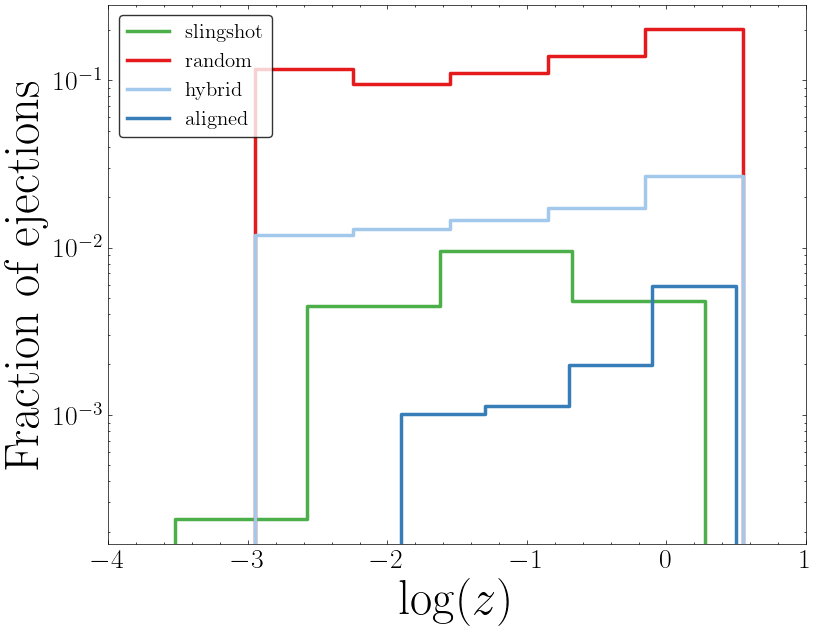

In [40]:
plt.figure(figsize=[9,7])
plt.step(bin_centers['slingshot'],np.mean(accumulated_fractions['slingshot'],axis=0),label="slingshot",linewidth =2.5,color=kick_colors['slingshot'])
plt.step(bin_centers['random'],np.mean(accumulated_fractions['random'],axis=0),label="random",linewidth =2.5,color=kick_colors['random'])
plt.step(bin_centers['hybrid'],np.mean(accumulated_fractions['hybrid'] ,axis=0),label="hybrid",linewidth =2.5,color=kick_colors['hybrid'])
plt.step(bin_centers['aligned'],np.mean(accumulated_fractions['aligned'],axis=0),label="aligned",linewidth =2.5,color=kick_colors['aligned'])
plt.xlim(-4,1)
plt.yscale("log")
plt.legend(fontsize=15, frameon=True, fancybox=True, framealpha=0.8, edgecolor="black",loc="upper left")
plt.xlabel("$\log (z)$",fontsize=35)
plt.ylabel("Fraction of ejections",fontsize=35)
plt.savefig("../Figures/ejection_fraction_for_total_population.pdf")

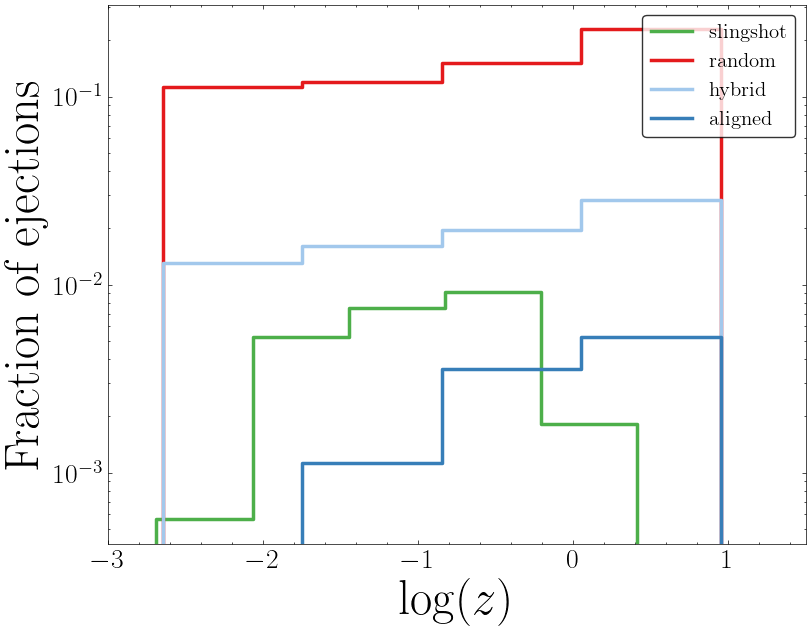

In [417]:
plt.figure(figsize=[9,7])
plt.step(bin_centers_sling,np.mean(accumulated_fraction_sling,axis=0),label="slingshot",linewidth =2.5,color=kick_colors['slingshot'])
plt.step(bin_centers_rand,np.mean(accumulated_fraction_rand,axis=0),label="random",linewidth =2.5,color=kick_colors['random'])
plt.step(bin_centers_hybrid,np.mean(accumulated_fraction_hybrid,axis=0),label="hybrid",linewidth =2.5,color=kick_colors['hybrid'])
plt.step(bin_centers_aligned,np.mean(accumulated_fraction_aligned,axis=0),label="aligned",linewidth =2.5,color=kick_colors['aligned'])
plt.xlim(-3,1.5)
plt.yscale("log")
plt.legend(fontsize=15, frameon=True, fancybox=True, framealpha=0.8, edgecolor="black",loc="upper right")
plt.xlabel("$\log (z)$",fontsize=35)
plt.ylabel("Fraction of ejections",fontsize=35)
plt.savefig("../Figures/ejection_fraction_for_total_population.pdf")

### Fraction of ejections total

In [8]:
fraction_random_eject = []
fraction_hybrid_eject = []
fraction_aligned_eject = []
fraction_slingshot_eject = []

for i in range(Nruns):
    # Total number of kicks for random spins
    N_mergers = np.sum(iso_bin.merger_mask)+np.sum(weak_tr.merger_mask)+np.sum(strong_tr[i].merger_mask)

    # Fraction of ejections for random spins
    fraction_random_eject.append(
        (np.sum(iso_bin.ejection_random_mask, axis=1) +
         np.sum(weak_tr.ejection_random_mask, axis=1) +
         np.sum(strong_tr[i].ejection_random_mask, axis=1)) /
        N_mergers
    )



    # Fraction of ejections for hybrid spins
    fraction_hybrid_eject.append(
        (np.sum(iso_bin.ejection_hybrid_mask, axis=1) +
         np.sum(weak_tr.ejection_hybrid_mask, axis=1) +
         np.sum(strong_tr[i].ejection_hybrid_mask, axis=1)) /
       N_mergers
    )



    # Fraction of ejections for aligned spins
    fraction_aligned_eject.append(
        (np.sum(iso_bin.ejection_aligned_mask, axis=1) +
         np.sum(weak_tr.ejection_aligned_mask, axis=1) +
         np.sum(strong_tr[i].ejection_aligned_mask, axis=1)) /
        N_mergers
    )



    # Fraction of ejections for slingshot kicks
    fraction_slingshot_eject.append(
        np.sum(strong_tr[i].ejection_slingshot_mask) / N_mergers
    )

# Output the results
print("In the total population")
print(f"Random ejection fraction: {np.mean(fraction_random_eject)*100:.4f} ± {np.std(fraction_random_eject)*100:.4f}")
print(f"Hybrid ejection fraction: {np.mean(fraction_hybrid_eject)*100:.4f} ± {np.std(fraction_hybrid_eject)*100:.4f}")
print(f"Aligned ejection fraction: {np.mean(fraction_aligned_eject)*100:.4f} ± {np.std(fraction_aligned_eject):.4f}")
print(f"Slingshot ejection fraction: {np.mean(fraction_slingshot_eject)*100:.4f} ± {np.std(fraction_slingshot_eject)*100:.4f}")

In the total population
Random ejection fraction: 14.0566 ± 0.4505
Hybrid ejection fraction: 1.7832 ± 0.1999
Aligned ejection fraction: 0.2283 ± 0.0006
Slingshot ejection fraction: 0.9952 ± 0.0144


In [9]:
fraction_random_eject = []
fraction_hybrid_eject = []
fraction_aligned_eject = []
fraction_slingshot_eject = []

for i in range(Nruns):
    # Total number of kicks for random spins
    N_mergers = 520

    # Fraction of ejections for random spins
    fraction_random_eject.append(
        (np.sum(strong_tr[i].ejection_random_mask, axis=1)) /
        N_mergers)

    # Fraction of ejections for hybrid spins
    fraction_hybrid_eject.append(
        (np.sum(strong_tr[i].ejection_hybrid_mask, axis=1)) /
       N_mergers
    )

    # Fraction of ejections for aligned spins
    fraction_aligned_eject.append(
        (np.sum(strong_tr[i].ejection_aligned_mask, axis=1)) /
        N_mergers
    )

    # Fraction of ejections for slingshot kicks
    fraction_slingshot_eject.append(
        np.sum((strong_tr[i].ejection_slingshot_mask)) / N_mergers)

# Output the results
print("In the strong triple population")
print(f"Random ejection fraction: {np.mean(fraction_random_eject)*100:.4f} ± {np.std(fraction_random_eject)*100:.4f}")
print(f"Hybrid ejection fraction: {np.mean(fraction_hybrid_eject)*100:.4f} ± {np.std(fraction_hybrid_eject)*100:.4f}")
print(f"Aligned ejection fraction: {np.mean(fraction_aligned_eject)*100:.4f} ± {np.std(fraction_aligned_eject):.4f}")
print(f"Slingshot ejection fraction: {np.mean(fraction_slingshot_eject)*100:.4f} ± {np.std(fraction_slingshot_eject)*100:.4f}")

In the strong triple population
Random ejection fraction: 9.3129 ± 1.1577
Hybrid ejection fraction: 0.9008 ± 0.3916
Aligned ejection fraction: 0.0612 ± 0.0010
Slingshot ejection fraction: 8.7346 ± 0.1281


### After accounting for ejections

In [113]:
iso_bin.bhid1 = iso_bin.binary_ids[:,0]
iso_bin.bhid2 = iso_bin.binary_ids[:,1]

weak_tr.bhid1 = weak_tr.bhid_inner[:,0]
weak_tr.bhid2 = weak_tr.bhid_inner[:,1]
weak_tr.bhid3 = weak_tr.bhid_outer[:,0]
weak_tr.bhid4 = weak_tr.bhid_outer[:,1]

for i in range(Nruns):
    strong_tr[i].bhid1 = strong_tr[i].bhid_inner[:,0]
    strong_tr[i].bhid2 = strong_tr[i].bhid_inner[:,1]
    strong_tr[i].bhid3 = strong_tr[i].bhid_outer[:,0]
    strong_tr[i].bhid4 = strong_tr[i].bhid_outer[:,1]

iso_invalid_merger_mask = np.zeros_like(iso_bin.bhid1, dtype=bool)
weak_triple_invalid_merger_mask = np.zeros_like(weak_tr.bhid1, dtype=bool)
strong_triple_invalid_merger_mask = np.zeros_like(strong_tr[0].bhid1, dtype=bool)

In [54]:
bhid_cols_in_iso_bins = {"bhid1","bhid2"}
bhid_cols_in_trips = {"bhid1","bhid2","bhid3","bhid4"}

In [55]:
iso_invalid_merger_masks = []

In [83]:
len(strong_tr[0].ejection_random_mask)

10

In [100]:
def find_invalid_mergers(strong_tr,weak_tr,iso_bin,ejection_mask_key,spin_i=0):

    iso_invalid_merger_mask = np.zeros_like(iso_bin.bhid1, dtype=bool)
    weak_triple_invalid_merger_mask = np.zeros_like(weak_tr.bhid1, dtype=bool)
    strong_triple_invalid_merger_mask = np.zeros_like(strong_tr.bhid1, dtype=bool)
    
    iso_bin_eject_mask = getattr(iso_bin,ejection_mask_key)[spin_i]
    weak_tr_eject_mask = getattr(weak_tr,ejection_mask_key)[spin_i]
    strong_tr_eject_mask = getattr(strong_tr,ejection_mask_key)[spin_i]

    #iso binaries affected by "ejection_mask_key"

    for i, bhid_x in enumerate(bhid_cols_in_iso_bins):
        for j, bhid_y in enumerate(bhid_cols_in_iso_bins):
                common_occurrences_of_y_ejected_in_x = np.in1d(getattr(iso_bin,bhid_x),getattr(iso_bin,bhid_y)[iso_bin.merger_mask][iso_bin_eject_mask])
                bhidx_indices = np.where(common_occurrences_of_y_ejected_in_x)[0]
                if len(bhidx_indices) > 0:
                        bhidy_indices = np.array([np.where(getattr(iso_bin,bhid_y) == getattr(iso_bin,bhid_x)[i])[0][0] for i in bhidx_indices])
                        different_indices_mask = bhidx_indices != bhidy_indices
                        bhidx_t_merger = iso_bin.t_merge[bhidx_indices]
                        bhidy_t_merger = iso_bin.t_merge[bhidy_indices]
                        iso_invalid_merger_mask[bhidx_indices[different_indices_mask]] |= bhidy_t_merger[different_indices_mask] < bhidx_t_merger[different_indices_mask]
                else:
                        continue
                
        for k,bhid_z in enumerate(bhid_cols_in_trips):
            common_occurrences_of_z_ejected_in_x = np.in1d(getattr(iso_bin,bhid_x),getattr(weak_tr,bhid_z)[weak_tr.merger_mask][weak_tr_eject_mask])
            bhidx_indices = np.where(common_occurrences_of_z_ejected_in_x)[0]
            if len(bhidx_indices) > 0:
                bhidz_indices = np.array([np.where(getattr(weak_tr,bhid_z) == getattr(iso_bin,bhid_x)[i])[0][0] for i in bhidx_indices])
                different_indices_mask = bhidx_indices != bhidz_indices
                bhid1_t_merger = iso_bin.t_merge[bhidx_indices]
                bhid_wt_t_form = weak_tr.t_triple_form[bhidz_indices]
                iso_invalid_merger_mask[bhidx_indices[different_indices_mask]] |=  bhid_wt_t_form[different_indices_mask] < bhid1_t_merger[different_indices_mask]
                #weak_triple_invalid_merger_mask[bhidz_indices[different_indices_mask]] |= bhid1_t_merger[different_indices_mask] < bhid_wt_t_form[different_indices_mask]
            else:
                continue

            common_occurrences_of_strong_ejected_in_x = np.in1d(getattr(iso_bin,bhid_x),getattr(strong_tr,bhid_z)[strong_tr.merger_mask][strong_tr_eject_mask])
            bhidx_indices = np.where(common_occurrences_of_strong_ejected_in_x)[0]
            if len(bhidx_indices) > 0:
                bhidz_indices = np.array([np.where(getattr(strong_tr,bhid_z) == getattr(iso_bin,bhid_x)[i])[0][0] for i in bhidx_indices])
                different_indices_mask = bhidx_indices != bhidz_indices
                bhid1_t_merger = iso_bin.t_merge[bhidx_indices]
                bhid_st_t_form = strong_tr.t_triple_form[bhidz_indices]
                iso_invalid_merger_mask[bhidx_indices[different_indices_mask]] |=  bhid_st_t_form[different_indices_mask] < bhid1_t_merger[different_indices_mask]
                #strong_triple_invalid_merger_mask[bhidz_indices[different_indices_mask]] |= bhid1_t_merger[different_indices_mask] < bhid_wt_t_form[different_indices_mask]
            else:
                continue
            common_occurrences_of_sling_ejected_in_x = np.in1d(getattr(iso_bin,bhid_x),getattr(strong_tr,bhid_z)[strong_tr.ejection_slingshot_mask])
            bhidx_indices = np.where(common_occurrences_of_sling_ejected_in_x)[0]
            if len(bhidx_indices) > 0:
                bhidz_indices = np.array([np.where(getattr(strong_tr,bhid_z) == getattr(iso_bin,bhid_x)[i])[0][0] for i in bhidx_indices])
                different_indices_mask = bhidx_indices != bhidz_indices
                bhid1_t_merger = iso_bin.t_merge[bhidx_indices]
                bhid_st_t_form = strong_tr.t_triple_form[bhidz_indices]
                iso_invalid_merger_mask[bhidx_indices[different_indices_mask]] |=  bhid_st_t_form[different_indices_mask] < bhid1_t_merger[different_indices_mask]
    
    #weak triples affected by "ejection_mask_key"

    for i,bhid_x in enumerate(bhid_cols_in_trips):
        for j, bhid_y in enumerate(bhid_cols_in_iso_bins):
            common_occurrences_of_y_ejected_in_x = np.in1d(getattr(weak_tr,bhid_x),getattr(iso_bin,bhid_y)[iso_bin.merger_mask][iso_bin_eject_mask])
            bhidx_indices = np.where(common_occurrences_of_y_ejected_in_x)[0]
            
            if len(bhidx_indices) > 0:
                bhidy_indices = np.array([np.where(getattr(iso_bin,bhid_y) == getattr(weak_tr,bhid_x)[i])[0][0] for i in bhidx_indices])
                different_indices_mask = bhidx_indices != bhidy_indices
                bhidy_t_merger = iso_bin.t_merge[bhidy_indices]
                bhid_wt_t_form = weak_tr.t_triple_form[bhidx_indices]
                weak_triple_invalid_merger_mask[bhidx_indices[different_indices_mask]] |= bhidy_t_merger[different_indices_mask] < bhid_wt_t_form[different_indices_mask]

            else:
                continue

        for k, bhid_z in enumerate(bhid_cols_in_iso_bins):
            common_occurrences_of_y_ejected_in_x = np.in1d(getattr(weak_tr,bhid_x),getattr(weak_tr,bhid_z)[weak_tr.merger_mask][weak_tr_eject_mask])
            bhidx_indices = np.where(common_occurrences_of_y_ejected_in_x)[0]
            
            if len(bhidx_indices) > 0:
                bhidz_indices = np.array([np.where(getattr(weak_tr,bhid_z) == getattr(weak_tr,bhid_x)[i])[0][0] for i in bhidx_indices])
                different_indices_mask = bhidx_indices != bhidz_indices
                bhidz_t_form = weak_tr.t_triple_form[bhidz_indices]
                bhid_wt_t_form = weak_tr.t_triple_form[bhidx_indices]
                weak_triple_invalid_merger_mask[bhidx_indices[different_indices_mask]] |= bhidz_t_form[different_indices_mask] < bhid_wt_t_form[different_indices_mask]  
                
            else:
                continue
                
            common_occurrences_of_strong_ejected_in_x = np.in1d(getattr(weak_tr,bhid_x),getattr(strong_tr,bhid_z)[strong_tr.merger_mask][strong_tr_eject_mask])
            bhidx_indices = np.where(common_occurrences_of_strong_ejected_in_x)[0]
                
            if len(bhidx_indices) > 0:
                bhidz_indices = np.array([np.where(getattr(strong_tr,bhid_z) == getattr(weak_tr,bhid_x)[i])[0][0] for i in bhidx_indices])
                different_indices_mask = bhidx_indices != bhidz_indices
                bhid1_t_form = weak_tr.t_triple_form[bhidx_indices]
                bhid_wt_t_form =strong_tr.t_triple_form[bhidz_indices]
                weak_triple_invalid_merger_mask[bhidx_indices[different_indices_mask]] |= bhid1_t_form[different_indices_mask] < bhid_wt_t_form[different_indices_mask]
            
            else:
                continue

            common_occurrences_of_sling_ejected_in_x = np.in1d(getattr(weak_tr,bhid_x),getattr(strong_tr,bhid_z)[strong_tr.ejection_slingshot_mask])
            bhidx_indices = np.where(common_occurrences_of_sling_ejected_in_x)[0]
            
            if len(bhidx_indices) > 0:
                bhidz_indices = np.array([np.where(getattr(strong_tr,bhid_z) == getattr(weak_tr,bhid_x)[i])[0][0] for i in bhidx_indices])
                different_indices_mask = bhidx_indices != bhidz_indices
                bhid1_wt_t_form = weak_tr.t_triple_form[bhidx_indices]
                bhid_st_t_form = strong_tr.t_triple_form[bhidz_indices]
                weak_triple_invalid_merger_mask[bhidx_indices[different_indices_mask]] |=  bhid_st_t_form[different_indices_mask] < bhid1_wt_t_form[different_indices_mask]
            
            
    #strong triples affected by "gw-key"
                
    for i,bhid_x in enumerate(bhid_cols_in_trips):
        for j, bhid_y in enumerate(bhid_cols_in_iso_bins):
            
            common_occurrences_of_y_ejected_in_x = np.in1d(getattr(strong_tr,bhid_x),getattr(iso_bin,bhid_y)[iso_bin.merger_mask][iso_bin_eject_mask])
            bhidx_indices = np.where(common_occurrences_of_y_ejected_in_x)[0]

            if len(bhidx_indices) > 0:
                bhidy_indices = np.array([np.where(getattr(iso_bin,bhid_y) == getattr(strong_tr,bhid_x)[i])[0][0] for i in bhidx_indices])
                different_indices_mask = bhidx_indices != bhidy_indices
                bhidy_t_merger = iso_bin.t_merge[bhidy_indices]
                bhid_wt_t_form = strong_tr.t_triple_form[bhidx_indices]
                strong_triple_invalid_merger_mask[bhidx_indices[different_indices_mask]] |= bhidy_t_merger[different_indices_mask] < bhid_wt_t_form[different_indices_mask]

            else:
                continue

        for k, bhid_z in enumerate(bhid_cols_in_iso_bins):
            common_occurrences_of_y_ejected_in_x = np.in1d(getattr(strong_tr,bhid_x),getattr(weak_tr,bhid_z)[weak_tr.merger_mask][weak_tr_eject_mask])
            bhidx_indices = np.where(common_occurrences_of_y_ejected_in_x)[0]
            
            if len(bhidx_indices) > 0:
                bhidz_indices = np.array([np.where(getattr(weak_tr,bhid_z) == getattr(strong_tr,bhid_x)[i])[0][0] for i in bhidx_indices])
                different_indices_mask = bhidx_indices != bhidz_indices
                bhidz_t_form = weak_tr.t_triple_form[bhidz_indices]
                bhid_wt_t_form = strong_tr.t_triple_form[bhidx_indices]
                strong_triple_invalid_merger_mask[bhidx_indices[different_indices_mask]] |= bhidz_t_form[different_indices_mask] < bhid_wt_t_form[different_indices_mask]  
                
            else:
                continue
                
            common_occurrences_of_strong_ejected_in_x = np.in1d(getattr(strong_tr,bhid_x),getattr(strong_tr,bhid_z)[strong_tr.merger_mask][strong_tr_eject_mask])
            bhidx_indices = np.where(common_occurrences_of_strong_ejected_in_x)[0]
                
            if len(bhidx_indices) > 0:
                bhidz_indices = np.array([np.where(getattr(strong_tr,bhid_z) == getattr(strong_tr,bhid_x)[i])[0][0] for i in bhidx_indices])
                different_indices_mask = bhidx_indices != bhidz_indices
                bhid_wt_t_form = strong_tr.t_triple_form[bhidz_indices]
                bhid1_t_form = strong_tr.t_triple_form[bhidx_indices]
                strong_triple_invalid_merger_mask[bhidx_indices[different_indices_mask]] |= bhid1_t_form[different_indices_mask] < bhid_wt_t_form[different_indices_mask]
            
            else:
                continue

            common_occurrences_of_sling_ejected_in_x = np.in1d(getattr(strong_tr,bhid_x),getattr(strong_tr,bhid_z)[strong_tr.ejection_slingshot_mask])
            bhidx_indices = np.where(common_occurrences_of_sling_ejected_in_x)[0]
            
            if len(bhidx_indices) > 0:
                bhidz_indices = np.array([np.where(getattr(strong_tr,bhid_z) == getattr(strong_tr,bhid_x)[i])[0][0] for i in bhidx_indices])
                different_indices_mask = bhidx_indices != bhidz_indices
                bhid1_wt_t_form = strong_tr.t_triple_form[bhidx_indices]
                bhid_st_t_form = strong_tr.t_triple_form[bhidz_indices]
                strong_triple_invalid_merger_mask[bhidx_indices[different_indices_mask]] |=  bhid_st_t_form[different_indices_mask] < bhid1_wt_t_form[different_indices_mask]

            else:
                continue


    return iso_invalid_merger_mask,weak_triple_invalid_merger_mask,strong_triple_invalid_merger_mask

In [134]:
def assign_invalid_merger_mask(strong_tr,weak_tr,iso_bin,spin_key):

    ejection_kick_mask = 'ejection_'+spin_key+'_mask'
    iso_inv_masks = []
    weak_inv_masks = []
    strong_inv_masks = []

    for i in range(N_kick_realization):
        realization_iso_masks = []   # Store iso masks for each realization
        realization_weak_masks = []  # Store weak masks for each realization
        realization_strong_masks = [] # Store strong masks for each realization
        
        for j in range(Nruns):
            # Find invalid mergers for the given realization and run
            iso_inv, weak_inv, strong_inv = find_invalid_mergers(
                strong_tr[j], weak_tr, iso_bin, ejection_kick_mask, spin_i=i
            )
            # Append masks for this run
            realization_iso_masks.append(iso_inv)
            realization_weak_masks.append(weak_inv)
            realization_strong_masks.append(strong_inv)
        
        # Append realization masks to the main lists
        iso_inv_masks.append(realization_iso_masks)
        weak_inv_masks.append(realization_weak_masks)
        strong_inv_masks.append(realization_strong_masks)

    # Convert the nested lists into 3D arrays if necessary
    iso_inv_masks = np.array(iso_inv_masks)  # Requires numpy
    weak_inv_masks = np.array(weak_inv_masks)
    strong_inv_masks = np.array(strong_inv_masks)

    setattr(iso_bin,spin_key+'_invalid_mask', iso_inv_masks)
    setattr(weak_tr,spin_key+'_invalid_mask', weak_inv_masks)
    setattr(strong_tr[0],spin_key+'_invalid_mask',strong_inv_masks)

In [175]:
assign_invalid_merger_mask(strong_tr,weak_tr,iso_bin,'random')
assign_invalid_merger_mask(strong_tr,weak_tr,iso_bin,'hybrid')
assign_invalid_merger_mask(strong_tr,weak_tr,iso_bin,'aligned')

In [167]:
tot_invalid_merger_fraction = []
for i in range(N_kick_realization):
    realization_tot_invalid = []
    for j in range(Nruns):
        iso_invalid_random = np.sum((iso_bin.merger_mask) & (iso_bin.random_invalid_mask[i][j]))
        iso_invalid_hybrid = np.sum((iso_bin.merger_mask) & (iso_bin.hybrid_invalid_mask[i][j]))
        iso_invalid_aligned = np.sum((iso_bin.merger_mask) & (iso_bin.aligned_invalid_mask[i][j]))
        iso_mergers = np.sum(iso_bin.merger_mask)

        weak_invalid = np.sum((weak_tr.merger_mask) & (weak_tr.random_invalid_mask[i][j]))
        weak_tr_mergers = np.sum(weak_tr.merger_mask)

        # Handle `strong_tr` assuming it's a list of objects
        strong_invalid = np.sum((strong_tr[j].merger_mask) & (strong_tr[0].random_invalid_mask[i][j]))
        strong_tr_mergers = np.sum(strong_tr[j].merger_mask)

        realization_tot_invalid.append((iso_invalid + weak_invalid + strong_invalid)/(iso_mergers+weak_tr_mergers+strong_tr_mergers))
        #realization_tot_invalid.append(np.sum((iso_bin.merger_mask)&(iso_bin.random_invalid_mask[i][j]))+np.sum((weak_tr.merger_mask)&(weak_tr.random_invalid_mask[i][j])))+ np.sum((strong_tr[j].merger_mask)&(strong_tr[0].random_invalid_mask[i][j]))
    tot_invalid_merger_fraction.append(realization_tot_invalid)

In [177]:
tot_invalid_merger_fraction = {
    'random': [],
    'hybrid': [],
    'aligned': []
}

for i in range(N_kick_realization):
    # Initialize lists to store results for each realization
    realization_tot_invalid_random = []
    realization_tot_invalid_hybrid = []
    realization_tot_invalid_aligned = []

    for j in range(Nruns):
        # For `iso_bin` mergers
        iso_invalid_random = np.sum((iso_bin.merger_mask) & (iso_bin.random_invalid_mask[i][j]))
        iso_invalid_hybrid = np.sum((iso_bin.merger_mask) & (iso_bin.hybrid_invalid_mask[i][j]))
        iso_invalid_aligned = np.sum((iso_bin.merger_mask) & (iso_bin.aligned_invalid_mask[i][j]))
        iso_mergers = np.sum(iso_bin.merger_mask)

        # For `weak_tr` mergers
        weak_invalid_random = np.sum((weak_tr.merger_mask) & (weak_tr.random_invalid_mask[i][j]))
        weak_invalid_hybrid = np.sum((weak_tr.merger_mask) & (weak_tr.hybrid_invalid_mask[i][j]))
        weak_invalid_aligned = np.sum((weak_tr.merger_mask) & (weak_tr.aligned_invalid_mask[i][j]))
        weak_tr_mergers = np.sum(weak_tr.merger_mask)

        # For `strong_tr` mergers (assuming `strong_tr` is a list)
        strong_invalid_random = np.sum((strong_tr[j].merger_mask) & (strong_tr[0].random_invalid_mask[i][j]))
        strong_invalid_hybrid = np.sum((strong_tr[j].merger_mask) & (strong_tr[0].hybrid_invalid_mask[i][j]))
        strong_invalid_aligned = np.sum((strong_tr[j].merger_mask) & (strong_tr[0].aligned_invalid_mask[i][j]))
        strong_tr_mergers = np.sum(strong_tr[j].merger_mask)

        # Calculate invalid fractions for random, hybrid, and aligned
        total_mergers = iso_mergers + weak_tr_mergers + strong_tr_mergers
        realization_tot_invalid_random.append((iso_invalid_random + weak_invalid_random + strong_invalid_random) / total_mergers)
        realization_tot_invalid_hybrid.append((iso_invalid_hybrid + weak_invalid_hybrid + strong_invalid_hybrid) / total_mergers)
        realization_tot_invalid_aligned.append((iso_invalid_aligned + weak_invalid_aligned + strong_invalid_aligned) / total_mergers)

    # Append results for this realization to the main lists
    tot_invalid_merger_fraction['random'].append(realization_tot_invalid_random)
    tot_invalid_merger_fraction['hybrid'].append(realization_tot_invalid_hybrid)
    tot_invalid_merger_fraction['aligned'].append(realization_tot_invalid_aligned)

In [190]:
print(f"{np.mean(tot_invalid_merger_fraction['random'])*100:.1f}% of mergers won't happen due to GW random + slingshot ejections")
print(f"{np.mean(tot_invalid_merger_fraction['hybrid'])*100:.1f}% of mergers won't happen due to GW hybrid + slingshot ejections")
print(f"{np.mean(tot_invalid_merger_fraction['aligned'])*100:.1f}% of mergers won't happen due to GW aligned + slingshot ejections")

5.6% of mergers won't happen due to GW random + slingshot ejections
1.6% of mergers won't happen due to GW hybrid + slingshot ejections
0.2% of mergers won't happen due to GW aligned + slingshot ejections


In [201]:
tot_merger_rate_after_ejection = {
    'random': [],
    'hybrid': [],
    'aligned': []
}

for i in tqdm(range(N_kick_realization),desc="calculating all merger rates after ejections for all spin realizations"):
    # Initialize lists to store results for each realization
    realization_tot_merger_rate_random = []
    realization_tot_merger_rate_hybrid = []
    realization_tot_merger_rate_aligned = []

    for j in range(Nruns):
        # For `iso_bin` mergers
        iso_random = mr.merger_rate_find(iso_bin.z_merger[(iso_bin.merger_mask) & (~iso_bin.random_invalid_mask[i][j])],zbinsize=0.2, zmax=7)[1]
        iso_hybrid = mr.merger_rate_find(iso_bin.z_merger[(iso_bin.merger_mask) & (~iso_bin.hybrid_invalid_mask[i][j])],zbinsize=0.2, zmax=7)[1]
        iso_aligned = mr.merger_rate_find(iso_bin.z_merger[(iso_bin.merger_mask) & (~iso_bin.aligned_invalid_mask[i][j])],zbinsize=0.2, zmax=7)[1]

        weak_tr_random = mr.merger_rate_find(weak_tr.z_merger[(weak_tr.merger_mask) & (~weak_tr.random_invalid_mask[i][j])],zbinsize=0.2, zmax=7)[1]
        weak_tr_hybrid = mr.merger_rate_find(weak_tr.z_merger[(weak_tr.merger_mask) & (~weak_tr.hybrid_invalid_mask[i][j])],zbinsize=0.2, zmax=7)[1]
        weak_tr_aligned = mr.merger_rate_find(weak_tr.z_merger[(weak_tr.merger_mask) & (~weak_tr.aligned_invalid_mask[i][j])],zbinsize=0.2, zmax=7)[1]


        strong_random = mr.merger_rate_find(strong_tr[i].z_triple_merger[(strong_tr[i].merger_mask) & (~strong_tr[0].random_invalid_mask[i][j])],zbinsize=0.2, zmax=7)[1]
        strong_hybrid = mr.merger_rate_find(strong_tr[i].z_triple_merger[(strong_tr[i].merger_mask) & (~strong_tr[0].hybrid_invalid_mask[i][j])],zbinsize=0.2, zmax=7)[1]
        strong_aligned = mr.merger_rate_find(strong_tr[i].z_triple_merger[(strong_tr[i].merger_mask) & (~strong_tr[0].aligned_invalid_mask[i][j])],zbinsize=0.2, zmax=7)[1]

        realization_tot_merger_rate_random.append(iso_random + weak_tr_random + strong_random)
        realization_tot_merger_rate_hybrid.append(iso_hybrid + weak_tr_hybrid + strong_hybrid)
        realization_tot_merger_rate_aligned.append(iso_aligned + weak_tr_aligned + strong_aligned)

    tot_merger_rate_after_ejection['random'].append(realization_tot_merger_rate_random)
    tot_merger_rate_after_ejection['hybrid'].append(realization_tot_merger_rate_hybrid)
    tot_merger_rate_after_ejection['aligned'].append(realization_tot_merger_rate_aligned)


calculating all merger rates after ejections for all spin realizations: 100%|██████████| 10/10 [3:13:36<00:00, 1161.70s/it] 


In [210]:
print(f"The merger rate after accounting for random ejections : {np.mean(tot_merger_rate_after_ejection['random']):.3f} yr^-1")
print(f"The merger rate after accounting for hybrid ejections : {np.mean(tot_merger_rate_after_ejection['aligned']):.4f} yr^-1")
print(f"The merger rate after accounting for aligned ejections : {np.mean(tot_merger_rate_after_ejection['hybrid']):.4f} yr^-1")

The merger rate after accounting for random ejections : 0.387 yr^-1
The merger rate after accounting for hybrid ejections : 0.4018 yr^-1
The merger rate after accounting for aligned ejections : 0.3991 yr^-1


In [200]:
mr.merger_rate_find(iso_bin.z_merger[(iso_bin.merger_mask)& (~iso_bin.random_invalid_mask[0][0])],zbinsize=0.2, zmax=7)[1]

0.35346643679945733

In [196]:
np.mean(tot_merger_rate_after_ejection['random'])

0.015520496692700664

In [355]:
tot_merger_rate = []
tot_merger_rate_after_ejec = []

for i in range(Nruns):
    weak_mr = mr.merger_rate_find(weak_tr.z_merger[(weak_tr.merger_mask)],zbinsize=0.2, zmax=7)[1]
    iso_mr = mr.merger_rate_find(iso_bin.z_merger[(iso_bin.merger_mask)],zbinsize=0.2, zmax=7)[1]
    strong_mr = mr.merger_rate_find(strong_tr[i].z_triple_merger[(strong_tr[i].merger_mask)],zbinsize=0.2, zmax=7)[1]

    tot_merger_rate.append(iso_mr+strong_mr+weak_mr)
    
    iso_inv_mask,weak_inv_mask,strong_inv_mask = Tr.find_invalid_mergers(strong_tr[0],weak_tr,iso_bin,"random")

    weak_mr = mr.merger_rate_find(weak_tr.z_merger[(weak_tr.merger_mask)&(~weak_inv_mask)],zbinsize=0.2, zmax=7)[1]
    iso_mr = mr.merger_rate_find(iso_bin.z_merger[(iso_bin.merger_mask)&(~iso_inv_mask)],zbinsize=0.2, zmax=7)[1]
    strong_mr = mr.merger_rate_find(strong_tr[i].z_triple_merger[(strong_tr[i].merger_mask)&(~strong_inv_mask)],zbinsize=0.2, zmax=7)[1]

    tot_merger_rate_after_ejec.append(iso_mr+strong_mr+weak_mr)


In [349]:
weak_mr = mr.merger_rate_find(weak_tr.z_merger[(weak_tr.merger_mask)],zbinsize=0.2, zmax=7)[1]
iso_mr = mr.merger_rate_find(iso_bin.z_merger[(iso_bin.merger_mask)],zbinsize=0.2, zmax=7)[1]
strong_mr = mr.merger_rate_find(strong_tr[0].z_triple_merger[(strong_tr[0].merger_mask)],zbinsize=0.2, zmax=7)[1]